In [1]:
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import cv2
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

print('Notebook running: keras ', keras.__version__)
np.random.seed(222)

Notebook running: keras  2.9.0


In [2]:
warnings.filterwarnings('ignore') 
inceptionV3_model =  keras.applications.inception_v3.InceptionV3()

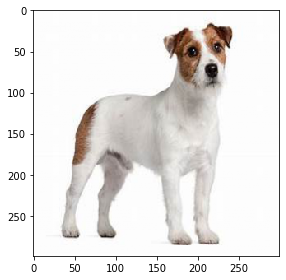

In [3]:
Xi = skimage.io.imread("F:/newimage/dog/387.jpeg")
Xi = skimage.transform.resize(Xi, (299,299)) 
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing

In [4]:
np.random.seed(222)
preds = inceptionV3_model.predict(Xi[np.newaxis,:,:,:])
decode_predictions(preds)[0] #Top 5 classes

1/1 [==============================] - 1s 1s/step


[('n02087046', 'toy_terrier', 0.4641632),
 ('n02095314', 'wire-haired_fox_terrier', 0.42221853),
 ('n02089973', 'English_foxhound', 0.020240856),
 ('n02101388', 'Brittany_spaniel', 0.009330567),
 ('n02086910', 'papillon', 0.0075505585)]

In [5]:
top_pred_classes = preds[0].argsort()[-6:][::-1]
top_pred_classes

array([158, 188, 167, 215, 157, 166], dtype=int64)

64


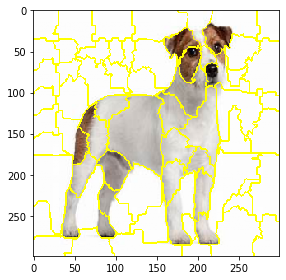

In [6]:
from skimage.segmentation import mark_boundaries
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
skimage.io.imshow(mark_boundaries(Xi/2+0.5,superpixels))
num_superpixels = np.unique(superpixels).shape[0]
print(num_superpixels)

In [7]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0])

In [8]:
print(perturbations)

[[1 1 1 ... 0 1 0]
 [1 0 1 ... 1 0 1]
 [0 0 0 ... 0 1 1]
 ...
 [0 0 1 ... 1 1 0]
 [0 1 1 ... 1 0 0]
 [0 1 0 ... 0 1 0]]


In [9]:
perturbations.shape

(150, 64)

In [10]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

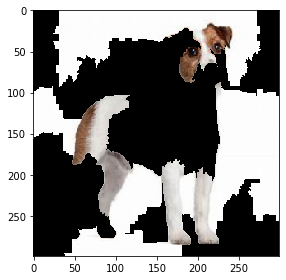

In [11]:
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

In [12]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = inceptionV3_model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions[0]

1/1 [==============================] - 0s 71ms/step


array([[5.59710061e-05, 8.28715492e-05, 1.39317941e-04, 2.43975337e-05,
        8.72368764e-05, 7.66743542e-05, 3.00022075e-05, 4.40967560e-04,
        1.17575364e-04, 6.04525194e-05, 3.69475783e-05, 5.24778516e-05,
        2.79922970e-05, 1.34019092e-05, 1.65092824e-05, 2.11718707e-05,
        3.36415396e-05, 2.01852599e-05, 1.24062644e-04, 2.29059442e-05,
        4.21120814e-04, 9.00193772e-05, 3.91067559e-04, 6.24818713e-05,
        1.17554000e-05, 5.18278503e-05, 5.35252366e-05, 4.15507093e-05,
        9.09882947e-05, 1.58127601e-04, 9.88773172e-05, 1.49261643e-04,
        6.78962970e-05, 1.22547181e-05, 6.84426559e-05, 3.64802618e-05,
        3.23403801e-05, 3.03421475e-05, 1.00887417e-04, 4.71094427e-05,
        1.89140737e-05, 3.83174593e-05, 1.05667314e-04, 1.04629355e-04,
        7.08049483e-05, 1.08485452e-04, 1.00372454e-04, 4.21955374e-05,
        1.29019376e-04, 6.02642976e-05, 3.88594890e-05, 1.56726106e-04,
        1.58592695e-04, 5.52117235e-05, 8.15284875e-05, 1.424218

In [13]:
active_block = np.unique(superpixels)
active_block

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63], dtype=int64)

In [14]:
def click_event(event, x, y, flags, params):
    x, y = y, x
    
    # checking for left mouse clicks
    if event == cv2.EVENT_LBUTTONDOWN:
        # displaying the coordinates
        print(x, ' ', y, ' blook = ', superpixels[x, y], end='\r')
        
        if superpixels[x, y] in inactive_block:
            inactive_block.remove(superpixels[x, y])
        else:
            inactive_block.append(superpixels[x, y])
 
        active_pixels = list(set(active_block).difference(set(inactive_block)))
    
        mask = np.zeros(superpixels.shape)
        for active in active_pixels:
            mask[superpixels == active] = 1
            
        perturbed_image = copy.deepcopy(Xi)
        perturbed_image = perturbed_image*mask[:,:,np.newaxis]
        img = perturbed_image[:, :, ::-1]
        
        cv2.imshow('image', img)

In [15]:
# reading the image
img = Xi[:, :, ::-1]

# displaying the image
cv2.imshow('image', img)

inactive_block = []

# setting mouse handler for the image and calling the click_event() function
cv2.setMouseCallback('image', click_event)

# wait for a key to be pressed to exit
cv2.waitKey(0)

# close the window
cv2.destroyAllWindows()

inactive_block.sort()
print(inactive_block)

[0, 3, 7, 13, 18, 25, 26, 29, 32, 33, 34, 37, 38, 40, 41, 42, 43, 44, 45, 48, 49, 54, 55]


In [16]:
array=np.array(inactive_block)

In [17]:
array.shape

(23,)

In [18]:
len(array)

23

In [19]:
predictions[0].shape

(1, 1000)

In [20]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
print(distances)

[0.30402945 0.25       0.26049003 0.3268544  0.25       0.30402945
 0.27113101 0.375      0.33856217 0.33856217 0.23965468 0.3153468
 0.28192967 0.35048095 0.22944825 0.27113101 0.33856217 0.3268544
 0.22944825 0.44098301 0.22944825 0.28192967 0.375      0.3153468
 0.3268544  0.38762756 0.3268544  0.375      0.29289322 0.29289322
 0.30402945 0.30402945 0.27113101 0.30402945 0.26049003 0.29289322
 0.27113101 0.29289322 0.28192967 0.3268544  0.29289322 0.3268544
 0.25       0.26049003 0.21937525 0.29289322 0.27113101 0.3153468
 0.30402945 0.27113101 0.28192967 0.29289322 0.28192967 0.27113101
 0.33856217 0.23965468 0.25       0.3153468  0.3268544  0.30402945
 0.27113101 0.27113101 0.27113101 0.30402945 0.26049003 0.375
 0.28192967 0.29289322 0.3153468  0.23965468 0.35048095 0.28192967
 0.30402945 0.28192967 0.30402945 0.3268544  0.25       0.3153468
 0.375      0.28192967 0.29289322 0.26049003 0.25       0.30402945
 0.26049003 0.3153468  0.29289322 0.23965468 0.25       0.28192967
 0.304

In [21]:
distances.shape

(150,)

In [22]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
print(weights)

[0.47736624 0.60653066 0.58109534 0.42542339 0.60653066 0.47736624
 0.55538361 0.32465247 0.39971849 0.39971849 0.63161519 0.45133345
 0.52947215 0.37430094 0.65627722 0.55538361 0.39971849 0.42542339
 0.65627722 0.21103567 0.65627722 0.52947215 0.32465247 0.45133345
 0.42542339 0.30058009 0.42542339 0.32465247 0.50343962 0.50343962
 0.47736624 0.47736624 0.55538361 0.47736624 0.58109534 0.50343962
 0.55538361 0.50343962 0.52947215 0.42542339 0.50343962 0.42542339
 0.60653066 0.58109534 0.68044791 0.50343962 0.55538361 0.45133345
 0.47736624 0.55538361 0.52947215 0.50343962 0.52947215 0.55538361
 0.39971849 0.63161519 0.60653066 0.45133345 0.42542339 0.47736624
 0.55538361 0.55538361 0.55538361 0.47736624 0.58109534 0.32465247
 0.52947215 0.50343962 0.45133345 0.63161519 0.37430094 0.52947215
 0.47736624 0.52947215 0.47736624 0.42542339 0.60653066 0.45133345
 0.32465247 0.52947215 0.50343962 0.58109534 0.60653066 0.47736624
 0.58109534 0.45133345 0.50343962 0.63161519 0.60653066 0.5294

In [23]:
weights.shape

(150,)

In [24]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
intercept =simpler_model.intercept_[0]

In [25]:
predictions[:,:,class_to_explain].shape

(150, 1)

In [26]:
print(coeff)

[ 1.25338056e-02 -8.91471128e-03 -5.29906918e-03 -5.82706343e-03
 -9.14977002e-04  8.17351614e-03 -1.69419870e-03 -5.42994695e-03
 -1.02106216e-02  7.12300021e-03 -1.78361179e-03 -7.33284026e-03
  5.60081555e-03  4.09281746e-03  4.07173471e-03  1.00061765e-02
 -2.10173592e-03 -8.20028711e-03  2.68905171e-02 -5.89523025e-03
 -2.06959829e-03  5.99584525e-03 -6.02015532e-03 -2.30960110e-03
 -6.93633251e-03  1.70413565e-02  2.78629234e-02  1.91491851e-03
  3.24177428e-03 -4.52375063e-03  1.48425170e-02 -1.56744605e-03
 -9.45148302e-03 -4.52208284e-03  1.62985522e-02 -1.71060685e-02
  9.54922003e-04 -1.13429364e-03  2.59159377e-03  2.64797603e-03
 -1.15994358e-02 -8.36485957e-03 -8.08095724e-04 -1.00864658e-02
  5.33085262e-03 -6.79532065e-03 -7.35077616e-03  1.22481198e-02
 -4.98478965e-03  1.66765583e-03  4.74567468e-03 -4.61716847e-03
  3.67415948e-03  6.53996672e-03 -7.08222274e-03  1.52807763e-03
  7.02918317e-03  4.51453518e-04 -2.43611855e-03 -7.99390679e-05
 -1.53588609e-02  8.54380

In [27]:
predictions[:,:,class_to_explain]

array([[2.40839808e-03],
       [6.03980850e-04],
       [8.29510158e-04],
       [7.86017452e-04],
       [1.18771673e-03],
       [2.04414013e-03],
       [1.76453067e-03],
       [2.76336796e-04],
       [5.00314520e-04],
       [1.55470974e-04],
       [1.55446772e-03],
       [3.11690685e-03],
       [1.30309520e-04],
       [2.18848023e-03],
       [8.87845890e-05],
       [5.20818681e-02],
       [4.10306937e-04],
       [4.00791317e-03],
       [1.99523685e-03],
       [9.00116938e-05],
       [2.14765985e-02],
       [1.57968421e-02],
       [1.64942394e-04],
       [1.40840551e-04],
       [4.07677889e-03],
       [3.37099633e-03],
       [1.38884690e-03],
       [5.77085325e-03],
       [2.33270388e-04],
       [1.82291085e-03],
       [1.75849441e-03],
       [4.36889706e-03],
       [1.06849649e-03],
       [1.38559414e-03],
       [2.41335165e-02],
       [1.27444032e-03],
       [6.01781234e-02],
       [3.28873359e-02],
       [5.19110635e-03],
       [3.67720984e-02],


In [28]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor

regr_rf=RandomForestRegressor()
regr_rf.fit(X=perturbations, y=predictions[:,:,class_to_explain],sample_weight=weights)

RandomForestRegressor()

In [29]:
y_pred=regr_rf.predict(perturbations)

In [30]:
y_pred

array([7.56215699e-03, 1.19126511e-03, 3.84670122e-03, 2.51444800e-03,
       3.46530113e-03, 3.21051289e-03, 1.16769863e-02, 9.24494058e-04,
       2.72353177e-03, 3.52798330e-03, 8.12970344e-03, 4.93393490e-03,
       6.42010396e-04, 5.93548931e-03, 5.91321310e-04, 3.39569558e-02,
       1.23384565e-03, 2.76653583e-03, 4.33545437e-03, 3.38004457e-03,
       2.48744833e-02, 2.54611395e-02, 3.14764188e-03, 1.01037875e-03,
       3.25469934e-02, 3.16966333e-03, 2.07548967e-03, 5.81681868e-03,
       1.79935707e-03, 2.75523083e-03, 4.98386731e-03, 1.05952520e-02,
       7.93417160e-03, 5.29926888e-03, 3.96567293e-02, 2.63893783e-02,
       5.82597707e-02, 1.02957152e-01, 2.33843871e-02, 4.48418742e-02,
       3.72689780e-03, 3.59332960e-03, 1.28430932e-01, 5.82200446e-04,
       3.42070686e-02, 4.11762058e-03, 9.67323427e-02, 3.43818210e-03,
       3.08565743e-03, 3.02165900e-03, 2.33491390e-02, 2.51949677e-03,
       2.21796197e-02, 2.21291872e-02, 5.78174104e-04, 3.12881333e-03,
      

In [31]:
importances = regr_rf.feature_importances_

In [32]:
importances

array([0.00786595, 0.013355  , 0.01440158, 0.06329071, 0.00209851,
       0.01937758, 0.01180779, 0.00497832, 0.00934965, 0.00753145,
       0.01087561, 0.0127495 , 0.00877748, 0.04055898, 0.02061943,
       0.001493  , 0.0017312 , 0.04020253, 0.12998267, 0.00350089,
       0.00777744, 0.00250219, 0.01170386, 0.02106742, 0.00618001,
       0.03186913, 0.11369986, 0.02082855, 0.01557325, 0.00588512,
       0.01124037, 0.00077901, 0.01048866, 0.00844603, 0.0478587 ,
       0.00357678, 0.00602755, 0.01186909, 0.01833517, 0.00552286,
       0.02305599, 0.004564  , 0.00770545, 0.01719934, 0.00869655,
       0.00114534, 0.0102635 , 0.00300162, 0.02289366, 0.00520624,
       0.00207778, 0.01405693, 0.00463024, 0.00290959, 0.01123097,
       0.00475569, 0.00769704, 0.00765427, 0.0140499 , 0.00533171,
       0.00852845, 0.01410828, 0.01191492, 0.0015437 ])

In [33]:
importances.shape

(64,)

In [34]:
num_top_features = len(array)
top_features2 = np.argsort(importances)[-num_top_features:] 
top_features2

array([62, 11,  1, 58, 51, 61,  2, 28, 43, 38,  5, 14, 27, 23, 48, 40, 25,
       17, 13, 34,  3, 26, 18], dtype=int64)

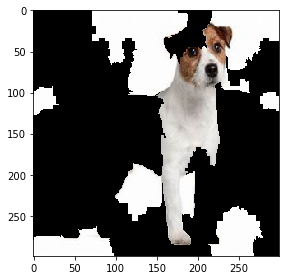

In [35]:
mask = np.zeros(num_superpixels) 
mask[top_features2]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )

In [36]:
intercept=simpler_model.intercept_[0]
intercept

0.00850537391629458

In [37]:
coeff.shape

(64,)

In [38]:
num_top_features = len(array)
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([38, 39, 28, 52, 14, 13, 50, 44, 12, 21, 53, 56,  9,  5, 61, 15, 47,
        0, 30, 34, 25, 18, 26], dtype=int64)

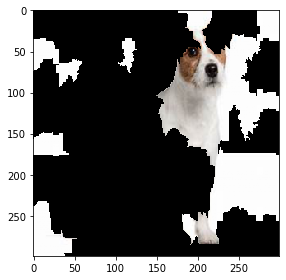

In [39]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )

In [71]:
rfTrue=(len(set(array) & set(top_features2))/len(array))

In [72]:
print(rfTrue)

0.43478260869565216


In [73]:
limeTrue=(len(set(array) & set(top_features))/len(array))

In [74]:
print(limeTrue)

0.34782608695652173


In [75]:
from sklearn import tree

In [76]:
treemodel=tree.DecisionTreeRegressor(max_depth=5)
treemodel.fit(perturbations,predictions[:,:,class_to_explain],sample_weight=weights)

DecisionTreeRegressor(max_depth=5)

In [77]:
importances = treemodel.feature_importances_

In [78]:
importances

array([0.00000000e+00, 6.08805441e-03, 0.00000000e+00, 2.69893683e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.38599602e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.74292500e-02, 0.00000000e+00, 6.42943546e-06,
       5.76610429e-03, 7.73714219e-05, 1.23302926e-01, 0.00000000e+00,
       0.00000000e+00, 5.08059485e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.59110530e-02, 1.33790242e-01, 0.00000000e+00,
       9.10029685e-03, 1.43520096e-04, 0.00000000e+00, 0.00000000e+00,
       3.87541588e-03, 6.71788483e-04, 1.62130004e-01, 0.00000000e+00,
       0.00000000e+00, 9.78581118e-03, 0.00000000e+00, 2.03316566e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       7.83612537e-05, 0.00000000e+00, 1.03293971e-06, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.26965470e-05, 0.00000000e+00,
      

In [79]:
importances.shape

(64,)

In [80]:
num_top_features = len(array)
top_features3 = np.argsort(coeff)[-num_top_features:] 
top_features3

array([38, 39, 28, 52, 14, 13, 50, 44, 12, 21, 53, 56,  9,  5, 61, 15, 47,
        0, 30, 34, 25, 18, 26], dtype=int64)

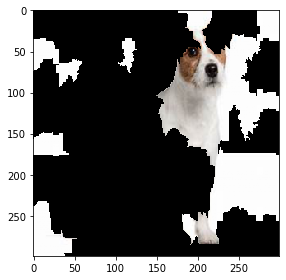

In [81]:
mask = np.zeros(num_superpixels) 
mask[top_features3]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )

In [82]:
TreeTrue=(len(set(array) & set(top_features3))/len(array))

In [83]:
print(TreeTrue)

0.34782608695652173


In [84]:
import xgboost as xgb

xgbrModel=xgb.XGBRegressor()
xgbrModel.fit(perturbations,predictions[:,:,class_to_explain],sample_weight=weights)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [85]:
importances=xgbrModel.feature_importances_

In [86]:
importances

array([2.44012801e-03, 9.38714854e-03, 4.99980804e-03, 1.53336614e-01,
       3.02044442e-04, 5.19928336e-03, 3.68828722e-03, 4.61116582e-02,
       3.66487005e-03, 1.84302463e-03, 4.05861996e-03, 5.19365247e-04,
       4.07957146e-03, 1.14789503e-02, 7.41401874e-03, 2.21684109e-03,
       2.15993682e-03, 1.38739064e-01, 4.05986197e-02, 2.05741511e-04,
       4.28815223e-02, 1.38657726e-03, 3.41636105e-03, 1.24665685e-02,
       1.40758920e-02, 2.89423503e-02, 7.67018497e-02, 7.81916489e-04,
       1.89769431e-03, 3.38111538e-03, 1.32072612e-03, 2.10194747e-04,
       4.54149616e-04, 7.21535413e-03, 9.49870348e-02, 2.36519030e-03,
       2.47592968e-03, 7.37784838e-04, 9.04676213e-04, 8.55822396e-03,
       9.56870522e-03, 2.90807430e-02, 4.84970456e-04, 6.37303740e-02,
       2.46095527e-02, 4.52793762e-02, 3.35444510e-03, 2.19823816e-03,
       4.40245168e-03, 4.18054580e-04, 5.22350334e-03, 1.58550905e-03,
       1.39427866e-04, 4.41244477e-03, 1.01398807e-02, 3.37185862e-04,
      

In [87]:
importances.shape

(64,)

In [88]:
num_top_features = len(array)
top_features4 = np.argsort(coeff)[-num_top_features:] 
top_features4

array([38, 39, 28, 52, 14, 13, 50, 44, 12, 21, 53, 56,  9,  5, 61, 15, 47,
        0, 30, 34, 25, 18, 26], dtype=int64)

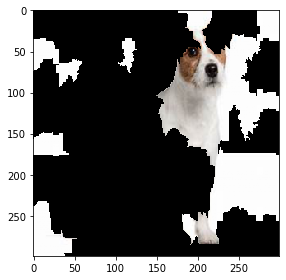

In [89]:
mask = np.zeros(num_superpixels) 
mask[top_features4]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )

In [90]:
xgbstTrue=(len(set(array) & set(top_features4))/len(array))

In [91]:
print(xgbstTrue)

0.34782608695652173
